In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
print(f"Using device: {device}")
import pandas as pd
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

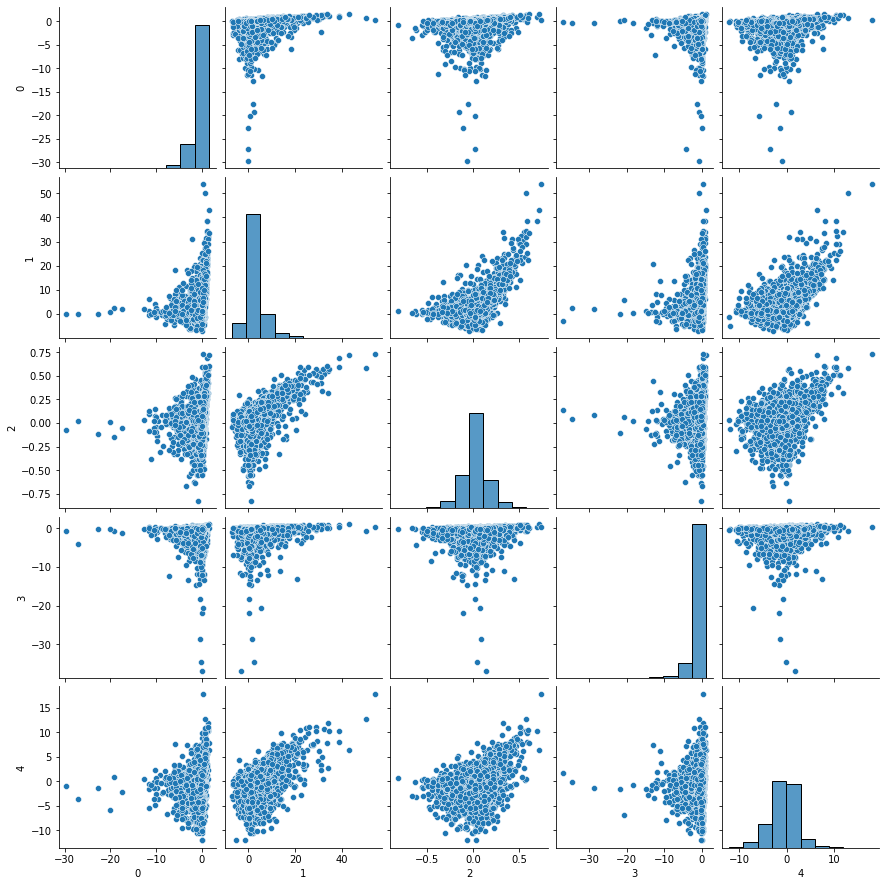

In [3]:
n_samples = 5000

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups


d = 5
# a = np.array([3,0.5,1,2,1.5])
a = np.array([3,0.5,1, 5,2])
beta = np.array([0, 0,0,0,0])
sig = np.array([0.3,3,0.1,0.2,1.5])
gamma = np.array([-0.1, 0.2, 0, -0.05, 0.1])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

In [5]:
data = torch.tensor(samples, dtype=torch.float, device = device)

In [6]:
memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

0.00G GPU memory allocated


In [7]:
dim = 5

base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)


num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

# f_T_model.sample(num_samples=2 ** 7)
# z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(15, 15))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()

batch_size = 128
loss_history = []
epochs = 30

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=100000)


optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )
# for name, param in model.named_parameters():
#     print(name, param)



Epoch 1/30, Loss: 2334249.4705
Epoch 0 - Learning Rate: 0.01


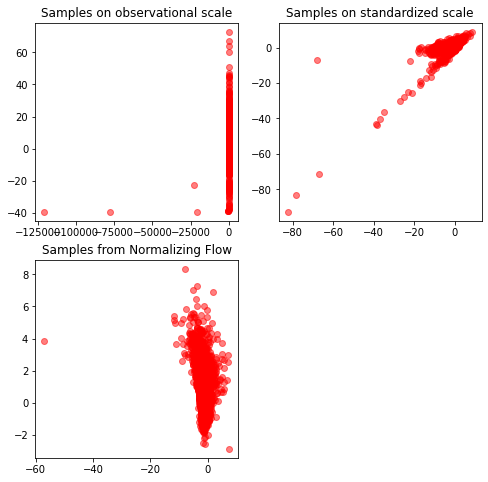

Epoch 2/30, Loss: 33.4718
Epoch 1 - Learning Rate: 0.009972609476841367
Epoch 3/30, Loss: 30.9585
Epoch 2 - Learning Rate: 0.009890738003669028
Epoch 4/30, Loss: 30.6179
Epoch 3 - Learning Rate: 0.009755282581475769
Epoch 5/30, Loss: 30.4460
Epoch 4 - Learning Rate: 0.009567727288213004
Epoch 6/30, Loss: 30.2492
Epoch 5 - Learning Rate: 0.009330127018922194
Epoch 7/30, Loss: 30.2970
Epoch 6 - Learning Rate: 0.009045084971874737
Epoch 8/30, Loss: 30.3012
Epoch 7 - Learning Rate: 0.00871572412738697
Epoch 9/30, Loss: 30.4561
Epoch 8 - Learning Rate: 0.008345653031794291
Epoch 10/30, Loss: 30.1251
Epoch 9 - Learning Rate: 0.007938926261462365
Epoch 11/30, Loss: 30.3723
Epoch 10 - Learning Rate: 0.007499999999999999


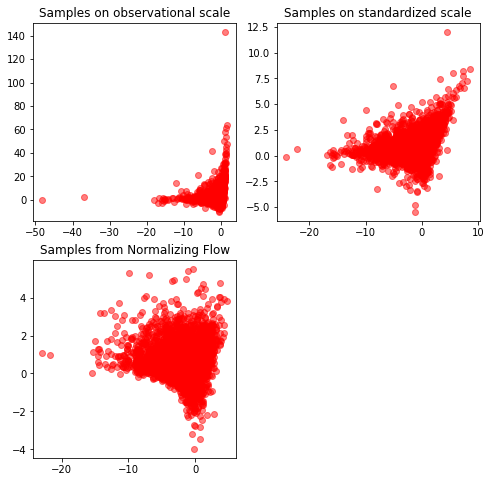

Epoch 12/30, Loss: 30.1766
Epoch 11 - Learning Rate: 0.007033683215379001
Epoch 13/30, Loss: 30.0993
Epoch 12 - Learning Rate: 0.0065450849718747366
Epoch 14/30, Loss: 30.0344
Epoch 13 - Learning Rate: 0.006039558454088796
Epoch 15/30, Loss: 29.8742
Epoch 14 - Learning Rate: 0.0055226423163382676
Epoch 16/30, Loss: 29.6548
Epoch 15 - Learning Rate: 0.005000000000000001
Epoch 17/30, Loss: 29.7520
Epoch 16 - Learning Rate: 0.0044773576836617335
Epoch 18/30, Loss: 29.6721
Epoch 17 - Learning Rate: 0.003960441545911203
Epoch 19/30, Loss: 29.5634
Epoch 18 - Learning Rate: 0.003454915028125263
Epoch 20/30, Loss: 29.5153
Epoch 19 - Learning Rate: 0.0029663167846209998
Epoch 21/30, Loss: 29.7346
Epoch 20 - Learning Rate: 0.002500000000000001


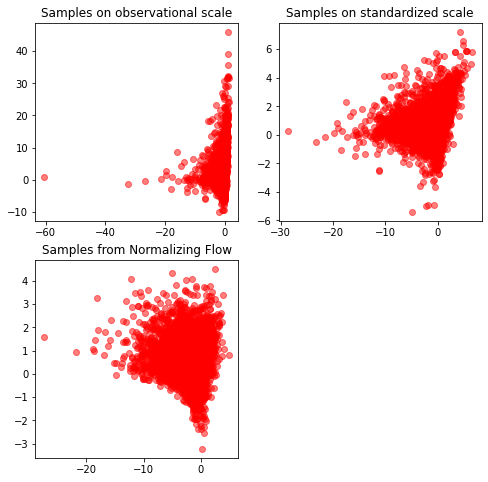

Epoch 22/30, Loss: 29.4816
Epoch 21 - Learning Rate: 0.0020610737385376348
Epoch 23/30, Loss: 29.5563
Epoch 22 - Learning Rate: 0.0016543469682057104
Epoch 24/30, Loss: 29.4379
Epoch 23 - Learning Rate: 0.0012842758726130299
Epoch 25/30, Loss: 29.4290
Epoch 24 - Learning Rate: 0.0009549150281252634
Epoch 26/30, Loss: 29.1457
Epoch 25 - Learning Rate: 0.0006698729810778065
Epoch 27/30, Loss: 29.1461
Epoch 26 - Learning Rate: 0.00043227271178699516
Epoch 28/30, Loss: 29.1867
Epoch 27 - Learning Rate: 0.00024471741852423234
Epoch 29/30, Loss: 29.2601
Epoch 28 - Learning Rate: 0.00010926199633097157
Epoch 30/30, Loss: 29.1673
Epoch 29 - Learning Rate: 2.7390523158632995e-05


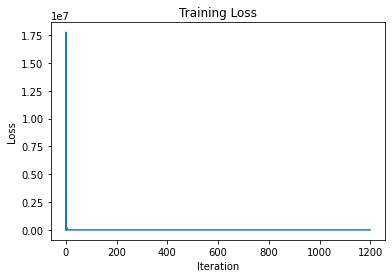

In [8]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, verbose=True
# )


Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")
    # Debugging: Print shapes

    if epoch % 10 ==0:
        samples_obs, samples_std, samples_T= model.sample(n_samples)
        plt.figure(figsize=(8,8))
        plt.subplot(2, 2, 1)
        plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on observational scale')
        plt.subplot(2, 2, 2)
        plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on standardized scale')
        plt.subplot(2, 2, 3)
        plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [7]:
U

array([0.46056636, 0.02769639, 0.84791491, 0.769788  , 0.088323  ])

In [11]:
a.reshape(1,-1)

array([[3. , 0.5, 1. , 5. , 2. ]])

In [13]:
np.ones((10,5))*(a.reshape(1,-1))

array([[3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ],
       [3. , 0.5, 1. , 5. , 2. ]])

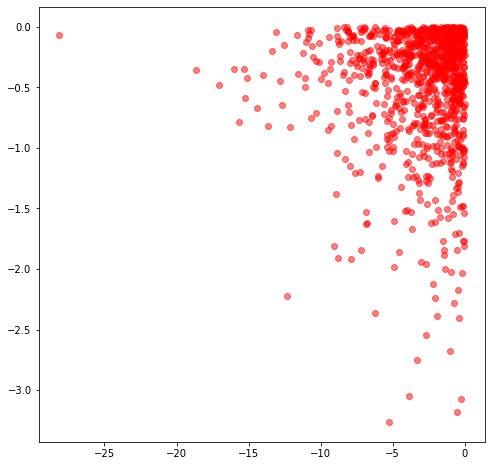

In [12]:
U = np.random.uniform(0, 1, (1000,5))
X_rev_exp = np.log(U)*(a.reshape(1,-1))
plt.figure(figsize=(8,8))
plt.scatter(X_rev_exp[:,0], X_rev_exp[:,1], alpha=0.5, color='red')

In [11]:
print(sig)
print(model.data_transform.get_sigma())
print(gamma)
print(model.data_transform.get_gamma())

[0.3 3.  0.1 0.2 1.5]
tensor([0.3028, 2.9573, 0.0987, 0.2073, 1.4673], device='cuda:0',
       grad_fn=<ClampBackward1>)
[-0.1   0.2   0.   -0.05  0.1 ]
tensor([-0.1135,  0.1920, -0.0023, -0.0851,  0.1039], device='cuda:0',
       grad_fn=<MulBackward0>)


# Wrong. Hessian is not on full paramter sapce, so its inverse is not the covariance matrix

In [12]:

params = torch.concat([model.data_transform.get_sigma().detach().requires_grad_(),
                      model.data_transform.get_gamma().detach().requires_grad_()])


def log_likelihood_batch(params):
 
    y = torch.zeros_like(x_data)
    
    sigma = params[:dim]
    gamma = params[dim:]
    
    sigma = sigma.unsqueeze(0)  # (1, dim)
    gamma = gamma.unsqueeze(0)  # (1, dim)

    # Exponential (inverse) case: y_j = (1/gamma_j)* log(1 + gamma_j*x_j / sigma_j)
    inside = 1.0 + (gamma * x_data) / sigma
    inside = torch.clamp(inside, min=1e-12) 
    y = (1.0 / gamma) * torch.log(inside)

    # 2) log prob under flow
    log_prob_y = model.log_prob_T_mGPD_std(y)


    # Build inside = sigma + gamma*x
    inside = sigma + gamma * x_data

    # log_abs_detJ per sample = - sum_j log(inside_j)
    log_abs_detJ = -torch.sum(torch.log(inside.abs() + 1e-12), dim=1)
    
    # => log p(x_data) = log p(y) + log|det dy/dx|
    log_prob_x = log_prob_y + log_abs_detJ
    # print(log_prob_x)
    ll = torch.sum(log_prob_x)
    return ll
FI = torch.zeros(2*dim, 2*dim,device=device)
for x_data in Training_Data:   
    FI += -torch.autograd.functional.hessian(log_likelihood_batch, params)
    
FI = FI.detach().cpu().numpy()
print(np.diag(FI))
cov = np.linalg.inv(FI)
print(np.diag(cov))

memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

[  9357.19     3166.4053  35768.953    7559.641   12924.145  153065.17
  61598.348  120567.586  137398.28   123789.6   ]
[1.6809064e-04 7.8566308e-04 3.4216017e-05 2.9701876e-04 9.7263553e-05
 1.0228799e-05 4.2603748e-05 9.1129714e-06 1.6326550e-05 9.1104421e-06]
0.05G GPU memory allocated


In [14]:
np.sqrt(np.diag(cov))

array([0.01296498, 0.02802968, 0.00584945, 0.01723423, 0.00986223,
       0.00319825, 0.00652715, 0.00301877, 0.00404061, 0.00301835],
      dtype=float32)

In [15]:
params = params.detach().cpu().numpy()
params

array([ 2.0033948 ,  2.914397  ,  0.97260886,  2.4775972 ,  1.4664329 ,
       -0.10934667,  0.19915311,  0.00565283, -0.20632212,  0.09864049],
      dtype=float32)

In [16]:
CI_low  = params- 1.96*np.sqrt(np.diag(cov))
CI_upp  = params+ 1.96*np.sqrt(np.diag(cov))

print(CI_low, CI_upp)

[ 1.9779835e+00  2.8594589e+00  9.6114397e-01  2.4438181e+00
  1.4471029e+00 -1.1561524e-01  1.8635988e-01 -2.6395777e-04
 -2.1424171e-01  9.2724517e-02] [ 2.0288062   2.969335    0.98407376  2.5113764   1.485763   -0.1030781
  0.21194634  0.01156962 -0.19840252  0.10455646]


# Plots

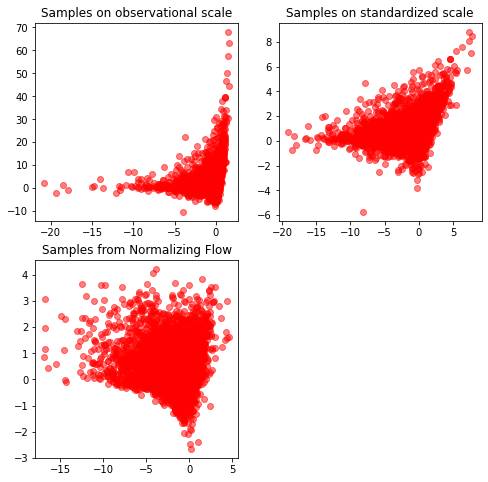

In [13]:
samples_obs, samples_std, samples_T= model.sample(n_samples)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [14]:
np.mean(abs(samples_T[:,0].cpu().data.numpy() - samples_T[:,1].cpu().data.numpy()))

np.float32(2.5106175)

In [15]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u


In [17]:
def chi_theorical(alpha1, alpha2):
    if alpha1 <= 0 or alpha2 <= 0:
        raise ValueError("alpha1 and alpha2 must be greater than 0")
    
    # Identify alpha_(1) = max(alpha1, alpha2) and alpha_(2) = min(alpha1, alpha2)
    alpha_max = max(alpha1, alpha2)
    alpha_min = min(alpha1, alpha2)
    
    # Calculate the components of the formula
    term1 = (1 + 1 / alpha_max) / (1 + 1 / alpha_min)
    term1_power = term1 ** (1 + alpha_min)
    term2 = (alpha_max / alpha_min) * (1 / (1 + alpha1 + alpha2))
    
    # Final chi value
    chi = 1 - term1_power * term2
    return chi

def pairwise_chi_theorical(alpha_vector):
    n = len(alpha_vector)
    chi_dict = {}
    
    for i in range(n-1):
        for j in range(i+1,n):
            chi_dict[f"{i+1}-{j+1}"] =  chi_theorical(alpha_vector[i], alpha_vector[j])
    
    return chi_dict


In [18]:
chi_values_theorical = pairwise_chi_theorical(1/a)
chi_values_theorical

{'1-2': np.float64(0.5132407700212496),
 '1-3': np.float64(0.4897639475816501),
 '1-4': np.float64(0.3318058612451248),
 '1-5': np.float64(0.4424743635628662),
 '2-3': np.float64(0.71875),
 '2-4': np.float64(0.40792321620687566),
 '2-5': np.float64(0.5959389821791157),
 '3-4': np.float64(0.39186245321194657),
 '3-5': np.float64(0.5645351568385462),
 '4-5': np.float64(0.3598892916940263)}

In [19]:
def pairwise_chi_empirical(data,model, n_bootstrap):
    probs = np.linspace(0.80, 0.996, 100)
    # Compute lambda_u for each quantile
    dim = data.shape[1]
    n_samples = data.shape[0]
    sample_chi = {}
    for i in range(dim-1):
        for j in range(i+1,dim):
            chi_values = []
            for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
                samples_obs, samples_std, samples_T= model.sample(n_samples)
                sampled_data = samples_obs.cpu().data.numpy()
                chi_values.append(empirical_upper_tail_dependence(sampled_data[:,[i,j]], 0.99))
            sample_chi[f"{i+1}-{j+1}"] =  chi_values
    
    return sample_chi

In [20]:
chi_values_empipical = pairwise_chi_empirical(data=samples,model=model, n_bootstrap=100)

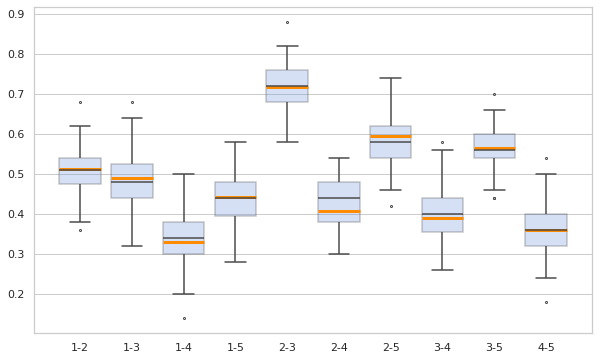

In [48]:
df = pd.DataFrame(chi_values_empipical)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
# ax.xaxis.grid(True)  # Enable vertical gridlines
# ax.yaxis.grid(True) 
for i, pair_index in enumerate(chi_values_theorical):
    plt.hlines(y=chi_values_theorical[pair_index], xmin=i - 0.4, xmax=i + 0.4, color='darkorange', linewidth=3)

In [71]:
def empirical_upper_tail_dependence(X, p, cond = 'and'):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = X[:,0] > quantile[0]
    if cond == 'and':
        for j in range(1,X.shape[1]):
            joint_exceedance &= X[:,j] > quantile[j]
    else:
        for j in range(1,X.shape[1]):
            joint_exceedance |= X[:,j] > quantile[j]
        
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    joint_exceedance = np.sum(joint_exceedance)
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u

def plot_tail_dependence(data, model, n_bootstrap, cond):
    probs = np.linspace(0.5, 0.999, 100)
    # Compute lambda_u for each quantile
    chi_emp = [empirical_upper_tail_dependence(data, p, cond) for p in probs]
    

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_chi = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
        sampled_data = samples_obs.cpu().data.numpy()
        sample_chi.append( [empirical_upper_tail_dependence(sampled_data, p, cond) for p in probs])

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_chi = np.array(sample_chi)
    lower_bound = np.percentile(sample_chi, 2.5, axis=0)
    upper_bound = np.percentile(sample_chi, 97.5, axis=0)
    mean = np.mean(sample_chi, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
    ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
    
    ax.set_title('Joint Chi', fontsize=14)

In [72]:
empirical_upper_tail_dependence(samples, 0.99, cond = 'or')
# plot_tail_dependence(samples, model=model, n_bootstrap= 20, cond='and')

np.float64(2.52)

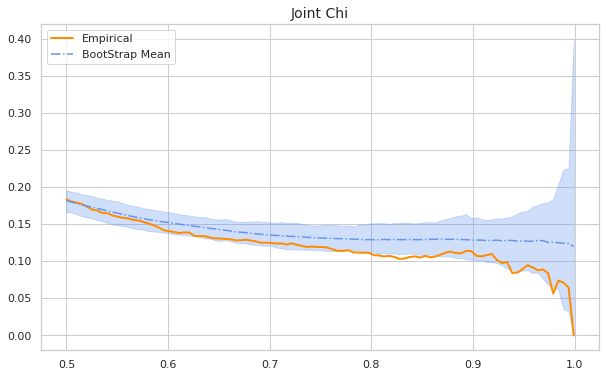

In [73]:
plot_tail_dependence(samples, model=model, n_bootstrap= 100, cond='and')

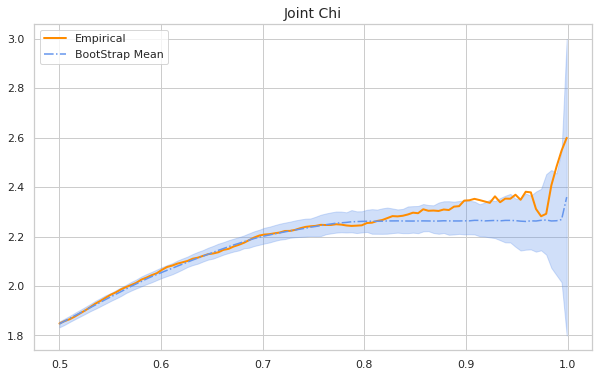

In [74]:
plot_tail_dependence(samples, model=model, n_bootstrap= 100, cond='or')